In [ ]:
import scipy.io
from scipy.spatial.distance import euclidean
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.image as img
from sklearn.cluster import KMeans
import cv2
import copy
from sklearn.metrics import f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_gt='drive/MyDrive/assignment2_pattern/BSR/BSDS500/data/groundTruth/test'#/2092.mat'
path_images='drive/MyDrive/assignment2_pattern/BSR/BSDS500/data/images/test'#train/2092.jpg'
path_saving='drive/MyDrive/assignment2_pattern/BSR/BSDS500/data/images/saved/'

##Loading Images and Ground Truth Segmentations

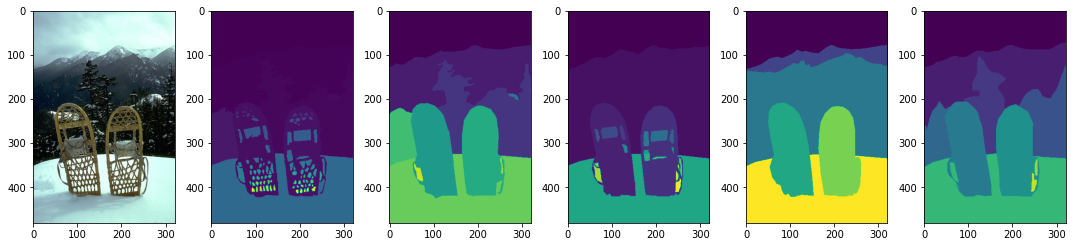

In [ ]:

og_images=[]
groundTruth=[]

##load original images
images = [og_image[:-4] for og_image in os.listdir(path_images) if os.path.isfile(os.path.join(path_images,og_image)) and og_image.endswith('jpg') ]
images.sort(key=int)
for og_image in images:
  og_image = og_image+'.jpg'
  og_images.append(img.imread(os.path.join(path_images, og_image))) 


gt_images = [gt_image[:-4] for gt_image in os.listdir(path_gt) if os.path.isfile(os.path.join(path_gt,gt_image))]
gt_images.sort(key=int)
for gt_image in gt_images:
  gt_image = gt_image+'.mat'
  gt=scipy.io.loadmat(os.path.join(path_gt,gt_image))
  gt_arr=[]
  for i in np.squeeze(gt['groundTruth']).reshape(-1):
    gt_arr.append(i[0][0][0])
  groundTruth.append(gt_arr)

fig, ax = plt.subplots(1, 6, figsize=(15,15))

ax[0].imshow(og_images[0])
for j in range(5):
  ax[j+1].imshow(groundTruth[0][j])
fig.tight_layout()  
plt.show()



##Segmentation Using Kmeans

K means algorithm

In [ ]:

class K_Means:
    def __init__(self, k, tol=0.001, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

    def fit(self,data):
     
        centroids_pos=np.random.randint(0,data.shape[0],self.k)     
        centroids=[data[centroids_pos[i]] for i in range(len(centroids_pos))]
      
        for iter in range(self.max_iter):
            labels=[]
            classifications = []

            for i in range(self.k):
                classifications.append([])

            for pixel in data:
                distances = [np.linalg.norm(pixel-centroids[j]) for j in range(len(centroids))]
                classification = distances.index(min(distances))
                labels.append(classification)
                classifications[classification].append(pixel)
                
            prev_centroids = copy.deepcopy(centroids)
        
            for c in range(self.k):
              if len(classifications[c])==0:
                centroids[c]= data[np.random.randint(0,data.shape[0])]
              else:
                centroids[c]=np.mean(classifications[c]) 
            change=0
            for i in range(self.k):
                change += np.linalg.norm(prev_centroids[i]-centroids[i]) 
            if change <= self.tol:
              break
              
        return labels


In [ ]:
kmeans_model=K_Means(3)
labels = kmeans_model.fit(np.float32(og_images[0].reshape(-1,3)))
# print(len(labels))

In [ ]:
def Color_Images(labels,image,k):
    colored_mat= np.zeros(image.shape,dtype=np.uint8)
    colors = []
    for i in range(k):
        colors.append(np.array([np.random.randint(0, 255),np.random.randint(0, 255),np.random.randint(0, 255)]))
    for i in range(image.shape[0]):
        colored_mat[i] = colors[labels[i]]
    return colored_mat

In [ ]:
K = [3,5,7,9,11]#
# segmented_imgs=[]
all_labels = []
for k in K:
  img_labels = [] 
  path_per_k = path_saving + 'k' +str(k)+ '/'
  for i in range(50):
    # # if k == 9:
    # if i in range(44):
    #     continue
     
    reshaped_img = og_images[i].reshape((-1, 3))
    reshaped_img = np.float32(reshaped_img)
    
    kmeans_model=K_Means(k)
    labels=kmeans_model.fit(reshaped_img)
    img_labels.append(labels)
    segmented_image = Color_Images(labels,reshaped_img,k)
    if og_images[i].shape[1] == 321: ## height 
      segmented_image=segmented_image.reshape(481,321,3)
    elif og_images[i].shape[0] == 321: ## width
      segmented_image=segmented_image.reshape(321,481,3)
    # if i in range(3):
    #   plt.figure(i)
    #   plt.title("K="+str(k))          
    #   plt.imshow(segmented_image)
    #   plt.show()

    img_name = str(i) + '.jpg'
    Image.fromarray(segmented_image,'RGB').save(path_per_k+img_name)  

  all_labels.append(img_labels)
      



## Kmeans Results

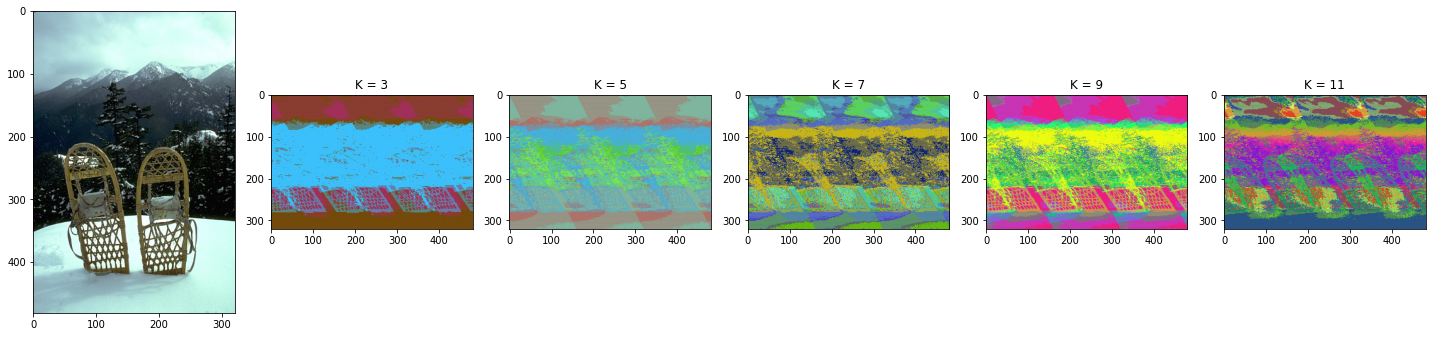

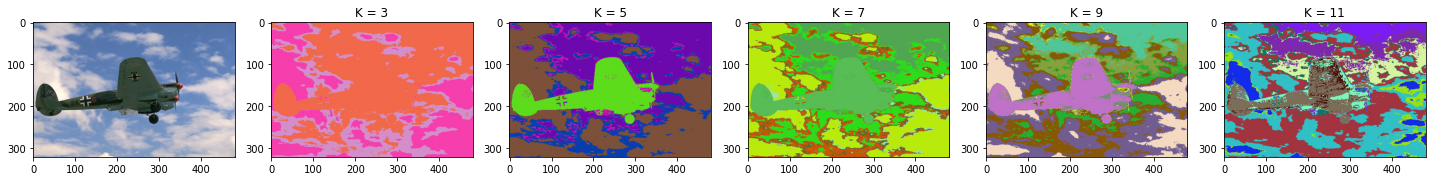

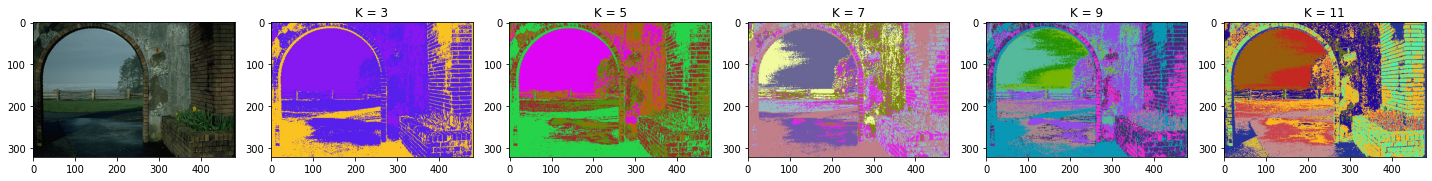

In [ ]:
K=[3,5,7,9,11]
segmentations=[]
for i in range(3):
  segmentations.append([])
  for k in K:
    path_per_k = path_saving + 'k' +str(k) + '/'
    image_name = str(i)+'.jpg' #str(k)+ 
    segmentations[i].append(img.imread(os.path.join(path_per_k,image_name)))



for i in range(3):
  fig, ax = plt.subplots(1, 6, figsize=(20,20))
  ax[0].imshow(og_images[i])
  for j in range(5):
    # print('hi2')
    ax[j+1].set_title("K = "+str(K[j]))
    ax[j+1].imshow(segmentations[i][j])
  fig.tight_layout()  
  plt.show()


## Comparison with ground truths

5
5


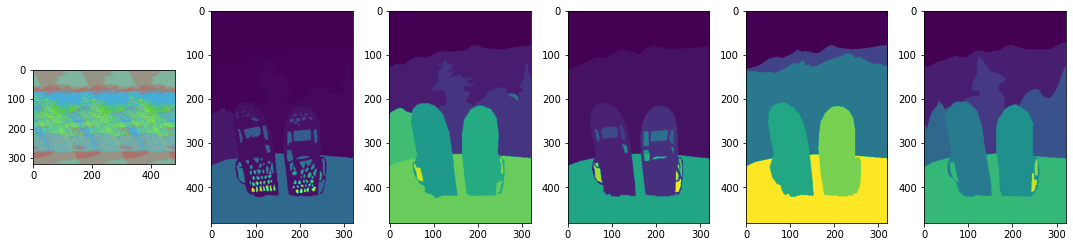

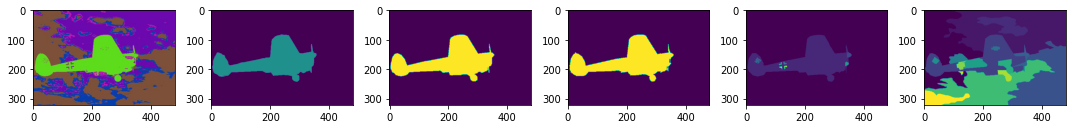

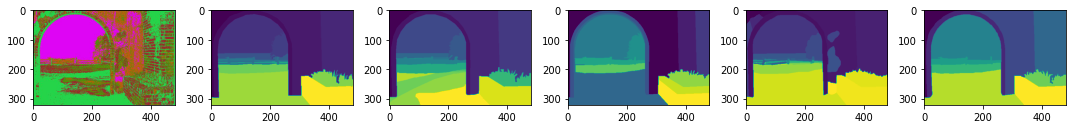

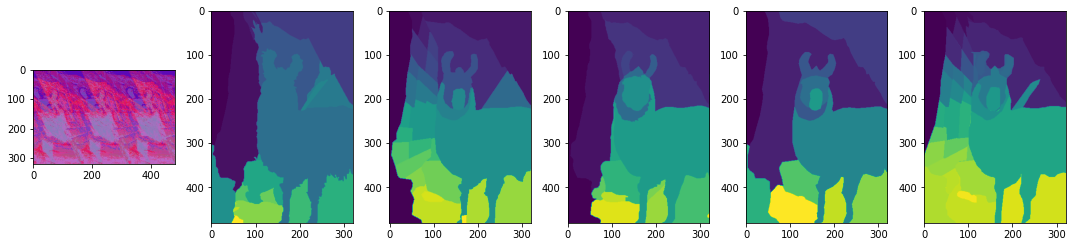

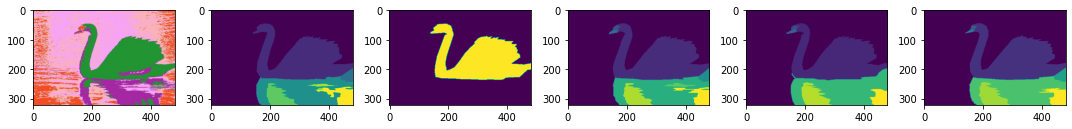

In [ ]:
path_k5 = path_saving + '/k5'
segs = [seg[:-4] for seg in os.listdir(path_saving) if os.path.isfile(os.path.join(path_k5,seg))]# and (seg.startswith('50.jpg') or seg.startswith('51.jpg') or seg.startswith('52.jpg') or seg.startswith('53.jpg') or seg.endswith('54.jpg')) ]
segs.sort(key=int)
kmeans_segs=[]
for seg in segs:
  seg=seg+'.jpg'
  kmeans_segs.append(img.imread(os.path.join(path_saving, seg)))

for i in range(5):

  
  fig, ax = plt.subplots(1, 6, figsize=(15,15))
  ax[0].imshow(kmeans_segs[i])
  for j in range(5):
    ax[j+1].imshow(groundTruth[i][j])
  fig.tight_layout()  
  plt.show()

